In [1]:
from glob import glob
import rasterio
import rasterio.mask
import geopandas as gpd
import fiona
import os
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#### Setting paths

In [2]:
GCS_IMAGE_PATH = 'gs://acn-cloudwars3-permafrost-training-data/RGB-thawslump-UTM-Images/'
VALIDATED_SHAPE_FILE_PATH = 'gs://acn-cloudwars3-permafrost-training-data/shapefiles/merged_thaw_slumps_validated/merged_thaw_slumps_validated.shp'
ALL_SHAPE_FILE_PATH = 'gs://acn-cloudwars3-permafrost-training-data/shapefiles/Thaw slumps_first iteration/merged_thaw_slumps.shp'

LOCAL_PATH='./MSI/'
#LOCAL_PATH= './test_128'

In [3]:
GCS_IMAGE_PATH + "**/*.tif"

'gs://acn-cloudwars3-permafrost-training-data/RGB-thawslump-UTM-Images/**/*.tif'

In [4]:
#!gsutil ls gs://acn-cloudwars3-permafrost-training-data/test_128/*.tif

In [5]:
#!gsutil -m cp -r gs://acn-cloudwars3-permafrost-training-data/test_128 ./

In [6]:
#files = glob(GCS_IMAGE_PATH + "**/*.tif")
#Doesnt seem to read directly from cloud bucket, code syntax seems correct but returns no files!

#### Copying from bucket to VM

In [7]:
#!gsutil cp -r gs://acn-cloudwars3-permafrost-training-data/RGB-thawslump-UTM-Images/MSI ./

In [21]:
files = glob(LOCAL_PATH + "**/*.tif")

In [9]:
files[100:110]

['./MSI/thaw/28-20190622_164801_1048.tif',
 './MSI/thaw/37-20190907_195118_1034.tif',
 './MSI/thaw/18-20190803_164436_1048.tif',
 './MSI/thaw/32-20190714_194358_1035.tif',
 './MSI/thaw/4-20190907_195118_1034.tif',
 './MSI/thaw/0-20190622_164801_1048.tif',
 './MSI/thaw/25-20190905_195023_1032.tif',
 './MSI/thaw/2-20190622_164802_1048.tif',
 './MSI/thaw/30-20190907_195118_1034.tif',
 './MSI/thaw/36-20190714_194359_1035.tif']

#### Explore n view .tif

In [4]:
#src = rasterio.open('./RGB-thawslump-UTM-Images/control/3-3.tif')
src = rasterio.open('./MSI/thaw/25-20190905_195023_1032.tif')
#src = rasterio.open('./RGB-thawslump-UTM-Images/thaw/0-20190710_214246_1001.tif')
#4-4 is 260 why? Rest 259
#2-2 is 259, 260

In [5]:
src.crs

CRS.from_epsg(32604)

In [25]:
array = src.read()
array.shape

(7, 263, 264)

In [189]:
np.nan_to_num(array[6], nan=0,copy=False)

img_temp = array[:4,:256,:256]
img_temp = img_temp/1000 # Hack but need to figure out correct value
img_final = np.moveaxis(img_temp, 0, -1)

In [190]:
  def load_image(image_path):
        """Load grayscale image
        :param image_path: path to image to load
        :return: loaded image
        """
        img_object = rasterio.open(image_path)
        img=img_object.read()
        #Selecting only 3 channels and fixing size to 256 not correct way exactly but hack
        channels=4
        size=64
        img_temp = img[:channels,:256,:256]
        img_temp = img_temp / 1000
        img_final = np.moveaxis(img_temp, 0, -1)
#         #Reducing image size to 40*40 crop from centre based on finding on 12/03 on thaw slump size being avg
#         #400m so 40 pixels
#         startx = 98 #(128-size/2)
#         starty = 98 #(128-size/2)
#         img_final = img_final[startx:startx+size,startx:starty+size,:]        
        return img_final

In [191]:
def load_mask(image_path):
    img_object = rasterio.open(image_path)
    img=img_object.read()
    #Selecting only 3 channels and fixing size to 256 not correct way exactly but hack
    channels=4
    size=64
    mask = img[-1,:256,:256]
    mask_final = np.moveaxis(mask, 0, -1)
    np.nan_to_num(mask_final, nan=0,copy=False)#Change nans from data to 0 for mask
    #Reducing image size to 40*40 crop from centre based on finding on 12/03 on thaw slump size being avg
    #400m so 40 pixels
#         startx = 98 #(128-size/2)
#         starty = 98 #(128-size/2)
#         mask_final = mask_final[startx:startx+size,startx:starty+size]   
    return mask_final

In [192]:
from data_generator_segmentation import DataGenerator_segmentation

In [193]:
#np.moveaxis(array, 0, -1).shape # Test moving channel to end

In [194]:
image_test=load_image(image_path='./MSI/thaw/25-20190905_195023_1032.tif')

In [195]:
mask_test= load_mask(image_path='./MSI/thaw/25-20190905_195023_1032.tif')

In [196]:
image_test.shape

(256, 256, 4)

In [197]:
mask_test.shape

(256, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


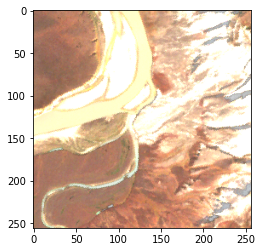

In [198]:
plt.imshow(image_test)
plt.show()

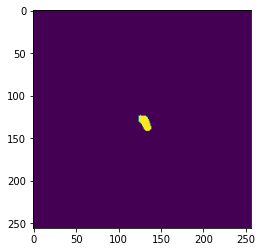

In [199]:
plt.imshow(mask_test)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


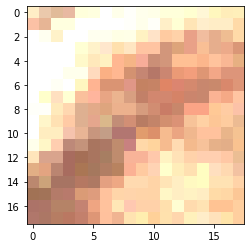

In [200]:
# Proves that crop to size 40*40 is better but maybe make it 100*100??
img_cropped = img_final[44:84, 44:84,:]
plt.imshow(img_cropped)
plt.show()
#but still images are very bad quality resolution and need to add more bands!!!!

<ipython-input-201-320644083592>:3: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax[0][0].imshow(array[0]);
<ipython-input-201-320644083592>:3: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax[0][0].imshow(array[0]);
<ipython-input-201-320644083592>:4: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax[0][1].imshow(array[1]);
<ipython-input-201-320644083592>:4: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax[0][1].imshow(array[1]);
<ipython-input-201-320644083592>:5: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax[1][0].imshow(array[2]);
<ipython-input-201-320644083592>:5: UserWarning: A

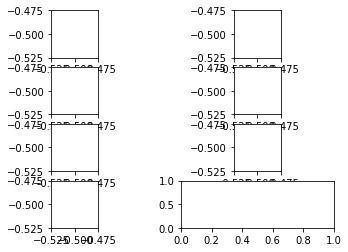

In [201]:
array = array[:,98:160,98:160]
fig, ax = plt.subplots(4,2)
ax[0][0].imshow(array[0]);
ax[0][1].imshow(array[1]);
ax[1][0].imshow(array[2]);
ax[1][1].imshow(array[3]);
ax[2][0].imshow(array[4]);
ax[2][1].imshow(array[5]);
ax[3][0].imshow(array[6]);

In [202]:
#array[6][20:44,20:44]

In [155]:
np.nan_to_num(array[6], nan=0,copy=False)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [156]:
np.unique(array[3], return_counts=True) # Should make it 0 when using as mask

(array([ 366.,  397.,  421.,  425.,  427.,  433.,  444.,  462.,  470.,
         483.,  487.,  489.,  493.,  506.,  507.,  512.,  514.,  517.,
         519.,  521.,  524.,  525.,  526.,  527.,  528.,  529.,  530.,
         531.,  532.,  533.,  534.,  535.,  536.,  537.,  538.,  539.,
         540.,  541.,  542.,  543.,  544.,  545.,  546.,  547.,  548.,
         550.,  552.,  553.,  554.,  556.,  557.,  558.,  559.,  560.,
         561.,  562.,  563.,  564.,  565.,  566.,  567.,  568.,  569.,
         570.,  571.,  572.,  573.,  574.,  575.,  576.,  578.,  579.,
         580.,  581.,  582.,  583.,  584.,  585.,  586.,  587.,  588.,
         589.,  590.,  591.,  592.,  594.,  595.,  596.,  597.,  598.,
         599.,  601.,  602.,  603.,  606.,  607.,  609.,  610.,  612.,
         613.,  614.,  615.,  618.,  619.,  620.,  621.,  623.,  627.,
         628.,  630.,  631.,  633.,  634.,  635.,  637.,  638.,  639.,
         640.,  641.,  643.,  645.,  646.,  647.,  648.,  651.,  655.,
      

#### Changing CRS of shape files (Not required anymore)

In [157]:
validated_shape_files = gpd.read_file(VALIDATED_SHAPE_FILE_PATH)
validated_shape_files = validated_shape_files.to_crs("EPSG:32604")
shapes = validated_shape_files['geometry']

DriverError: Fetching OAuth2 access code from auth code failed.

In [158]:
shapes

NameError: name 'shapes' is not defined

#### Find overlap of tif file and validated thaw slump polygon to build masks (Not required anymore)

In [159]:
#out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
#out_meta = src.meta

#Looks like the polygon shapes do not overlap with tif files even after changing CRS.
#Something wrong here. Check!

### Modelling Pipeline (Test)

In [160]:
IMG_HEIGHT=40
IMG_WIDTH=40
BATCH_SIZE = 8

##### Load image, preprocess, augment through image data generator

#### Custom data generator

In [161]:
df_dataset = pd.DataFrame()
df_dataset['image_paths'] = files
df_dataset['labels_string'] = df_dataset['image_paths'].str.split('\\').str[-2]
df_dataset['label'] =  df_dataset['labels_string'].apply(lambda x: 1 if x == 'thaw' else 0)
df_dataset = df_dataset.sample(frac=1).reset_index(drop=True) #Randomize

In [162]:
df_dataset['image_paths'].str.split('\\').str[-2]

0      no_thaw
1      no_thaw
2         thaw
3         thaw
4      no_thaw
        ...   
619       thaw
620       thaw
621       thaw
622    no_thaw
623    no_thaw
Name: image_paths, Length: 624, dtype: object

In [163]:
df_dataset

,image_paths,labels_string,label
0,./MSI\no_thaw\North_Canada487-487.tif,no_thaw,0
1,./MSI\no_thaw\North_Canada369-369.tif,no_thaw,0
2,./MSI\thaw\1-20190820_164142_0f21.tif,thaw,1
3,./MSI\thaw\29-20190907_195118_1034.tif,thaw,1
4,./MSI\no_thaw\North_Canada438-438.tif,no_thaw,0
...,...,...,...
619,./MSI\thaw\28-20190803_164436_1048.tif,thaw,1
620,./MSI\thaw\9-20190803_164438_1048.tif,thaw,1
621,./MSI\thaw\4-20190803_164436_1048.tif,thaw,1
622,./MSI\no_thaw\North_Canada360-360.tif,no_thaw,0


In [164]:
df_dataset.groupby('labels_string').count()

,image_paths,label
labels_string,,
no_thaw,311,311
thaw,313,313


In [180]:
train, test = train_test_split(df_dataset, test_size=0.2, stratify=df_dataset['label'], random_state=123)

In [181]:
train.groupby('labels_string').count()

,image_paths,label
labels_string,,
no_thaw,249,249
thaw,250,250


In [182]:
test.groupby('labels_string').count()

,image_paths,label
labels_string,,
no_thaw,62,62
thaw,63,63


In [204]:
#Custom data generator that replaces PIL function on image read of tiff record with rasterio 
#as default Imagedatagenertator seems to be throwing error

from data_generator_segmentation import DataGenerator_segmentation
train_generator = DataGenerator_segmentation(train)
test_generator = DataGenerator_segmentation(test)
#Add code for resize
#Add code for normalize range to 0-1
#Add code fro augmentations

In [205]:
x_ex=train_generator.__getitem__(1)

### Save model

In [185]:
x_ex[0][1][1]

array([[7.92799997, 6.90799999, 7.72800016],
       [8.36800003, 6.90399981, 7.9920001 ],
       [8.40799999, 6.78399992, 8.01599979],
       [7.89599991, 6.71199989, 7.83199978],
       [7.6960001 , 6.46400023, 7.69199991],
       [7.57999992, 6.53999996, 7.71600008],
       [7.57999992, 6.53999996, 7.71600008],
       [7.52799988, 6.42399979, 7.58400011],
       [7.65600014, 6.56799984, 7.55200005],
       [7.53599977, 6.46000004, 7.5       ],
       [7.63999987, 6.53999996, 7.61199999],
       [7.36399984, 6.48000002, 7.62400007],
       [7.36399984, 6.48000002, 7.62400007],
       [7.6960001 , 6.46000004, 7.57200003],
       [7.59600019, 6.43200016, 7.71600008],
       [7.63999987, 6.58799982, 7.704     ],
       [7.64799976, 6.37200022, 7.78800011],
       [7.54799986, 6.56400013, 7.68400002],
       [7.56799984, 6.48000002, 7.6079998 ],
       [7.56799984, 6.48000002, 7.6079998 ],
       [7.59200001, 6.45599985, 7.63600016],
       [7.86800003, 6.53200006, 7.58799982],
       [9.

In [186]:
#export_path = tf.contrib.saved_model.save_keras_model(model, 'keras_export')
#print("Model exported to: ", export_path)

In [187]:
def simple_convnet(IMG_HEIGHT=256, IMG_WIDTH=256):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                16,
                3,
                padding="same",
                activation="relu",
                input_shape=(IMG_HEIGHT, IMG_WIDTH, 4),
            ),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=1e-3
        ),  # this LR is overriden by base cycle LR if CyclicLR callback used
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    #print(model.summary())

    return model

model = simple_convnet(IMG_HEIGHT=256, IMG_WIDTH=256)

#### Load Pretrained model - MobileNet / Efficientnet

In [188]:
#from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, min_lr=0.000001, verbose=1, mode='min')
#Add checkpoints to rollback to best performing model

history = model.fit(train_generator,
steps_per_epoch=424//6,shuffle=True, 
epochs=30,
verbose=1,
validation_data = test_generator,callbacks=[early_stopping, reduce_lr])
#code works. Not enough data to train a model.

Epoch 1/30


ValueError: in user code:

    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\leo__\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 1) vs (None, None, None, None))


In [170]:
height = 256
width = 256
n_channels =4

In [171]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose, Concatenate, UpSampling2D, \
    BatchNormalization, Activation, Add, Multiply, Dropout, Lambda,MaxPooling2D,concatenate, Dense, Reshape
from tensorflow.keras.initializers import glorot_normal, he_normal, glorot_uniform, he_uniform
from tensorflow.keras.applications import MobileNetV2

inputs = Input(shape=(height, width, n_channels), name="MSI")
#encoder = MobileNetV2(input_tensor=inputs, weights='imagenet', include_top=False)

def convolution_block(x, filters):
    """
    This function builds the Conv2D block with variable filters

    Arguments:
        x: (Layer) previous layer of type Tensorflow.keras.layers
        filters : (int) number of filters
    Returns:    
        tensorflow.keras.layers.Conv2D block

    """ 
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def MobileUNet(height, width, n_channels, pretrained=True):
    """
    This function builds the model architecture for MobileUNet
    
    Arguments:
        height : (int) height of image
        width : (int) width of image
        n_channels : (int) number of channels in image
        pretrained : (boolean) whether to use the Imagenet pretrained weights for encoder

    Returns:    
        tensorflow.keras.Model

    """ 
    # Defining the number of filters at each stage of the decoder
    filters_layer = [16, 32, 64, 128]
    inputs = Input(shape=(height, width, n_channels), name="input_image")

    #Encoder    
    if pretrained=="True":
        encoder = MobileNetV2(input_tensor=inputs, weights='imagenet', include_top=False)
    else:
        encoder = MobileNetV2(input_tensor=inputs, weights=None, include_top=False)
    '''
    The following are the selected skip connecion layers from the MobileNetV2 architecture based on feature map resolution
    "input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu",block_13_expand_relu
    '''
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    #Decoder
    #Layer 3
    x = encoder_output
    x = UpSampling2D((2, 2))(x)
    x_skip_3 = encoder.get_layer(skip_connection_names[3]).output
    x = Concatenate()([x, x_skip_3])
    x = convolution_block(x, filters_layer[3])

    #Layer 2
    x = UpSampling2D((2, 2))(x)
    x_skip_2 = encoder.get_layer(skip_connection_names[2]).output
    x = Concatenate()([x, x_skip_2])
    x = convolution_block(x, filters_layer[2])

    #Layer 1
    x = UpSampling2D((2, 2))(x)
    x_skip_1 = encoder.get_layer(skip_connection_names[1]).output
    x = Concatenate()([x, x_skip_1])
    x = convolution_block(x, filters_layer[1])

    #Layer 0
    x = UpSampling2D((2, 2))(x)
    x_skip_0 = encoder.get_layer(skip_connection_names[0]).output
    x = Concatenate()([x, x_skip_0])
    x = convolution_block(x, filters_layer[0])

    #Output Layer
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [172]:
model = MobileUNet(height, width, n_channels, pretrained=True)

In [173]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 4)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 1152        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [174]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    """
    Arguments:
        y_true: (string) ground truth image mask
        y_pred : (int) predicted image mask

    Returns:    
        Calculated Dice coeffecient
    """
    y_true_f = K.flatten(y_true)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    """
    Arguments:
        y_true: (string) ground truth image mask
        y_pred : (int) predicted image mask

    Returns:    
        Calculated Dice coeffecient loss
    """
    return 1 - dice_coef(y_true, y_pred)

def dice_score(y_true, y_pred, smooth=1, threshold = 0.6):
    """
    Arguments:
        y_true: (string) ground truth image mask
        y_pred : (int) predicted image mask
        smooth : (float) smoothening to prevent divison by 0
        threshold : (float) threshold over which pixel is conidered positive

    Returns:    
        Calculated Dice coeffecient for evaluation metric
    """
    y_true_f = K.flatten(y_true)
    y_true_f = K.cast(y_true_f, 'float32')  
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), threshold), 'float32')
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth)/ (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

In [175]:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=1e-3
        ),  # this LR is overriden by base cycle LR if CyclicLR callback used
        loss=dice_coef_loss,
        metrics=dice_score,
    )

In [176]:
# train the model on the new data for a few epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, min_lr=0.000001, verbose=1, mode='min')

history = model.fit(train_generator,
steps_per_epoch=424//6,shuffle=True, 
epochs=30,
verbose=1,
validation_data = test_generator,callbacks=[early_stopping, reduce_lr])

Epoch 1/30


InvalidArgumentError:  input depth must be evenly divisible by filter depth: 3 vs 4
	 [[node functional_7/Conv1/Conv2D (defined at <ipython-input-176-683c68865c88>:7) ]] [Op:__inference_train_function_51423]

Function call stack:
train_function


In [77]:
x =(train_generator.__getitem__(1))

In [81]:
x

(array([[[[5.99599981, 5.61999989, 7.45599985],
          [6.23600006, 5.97599983, 7.8119998 ],
          [7.84000015, 6.90399981, 8.43200016],
          ...,
          [3.74600005, 3.38199997, 4.21199989],
          [3.37400007, 3.18199992, 4.11999989],
          [3.81999993, 3.32200003, 4.26399994]],
 
         [[6.00400019, 5.61199999, 7.46400023],
          [6.56799984, 5.90399981, 7.42799997],
          [9.70400047, 8.14000034, 9.52000046],
          ...,
          [2.86400008, 2.5999999 , 3.67400002],
          [2.71000004, 2.56599998, 3.52200007],
          [2.80200005, 2.86199999, 3.81999993]],
 
         [[5.86399984, 5.24399996, 7.06400013],
          [6.77199984, 5.84399986, 7.3920002 ],
          [8.25599957, 7.19199991, 8.45600033],
          ...,
          [2.68000007, 2.55599999, 3.52600002],
          [2.83400011, 2.7019999 , 3.5940001 ],
          [3.13400006, 2.91799998, 3.80599999]],
 
         ...,
 
         [[6.1880002 , 4.81599998, 4.96799994],
          [6.18800